In [1]:
import os
from dotenv import find_dotenv, load_dotenv

load_dotenv(find_dotenv())
src_path = os.environ.get('PROJECT_SRC')
os.chdir(src_path)

In [2]:
from data_reader_writer import data_writer

import pypsa

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 22})

## Low capacity, low network, and high demand - 2045

In [3]:
# scenario = 'Leading The Way'
# scenario = 'Consumer Transformation'
scenario = 'System Transformation'
# scenario = 'Steady Progression'
year = 2045
year_baseline = 2012

start = str(year) + '-12-04 20:00:00'
end = str(year) + '-12-10 20:00:00'
# time step as fraction of hour
time_step = 1
data_writer(start, end, time_step, year, demand_dataset='eload', year_baseline=year_baseline,
            scenario=scenario, FES=2022, merge_generators=True, scale_to_peak=True)

c:\Users\alyden\Anaconda3\envs\PyPSA-GB\lib\site-packages\pandas\core\arrays\datetimes.py:741: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  warnings.warn(
c:\Users\alyden\Anaconda3\envs\PyPSA-GB\lib\site-packages\pandas\core\indexing.py:1667: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = value
C:\Users\alyden\OneDrive - University of Edinburgh\Python\PyPSA-GB v0.0.1\PyPSA-GB\interconnectors.py:206: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  df_FES = df_FES[~df_FES.Variable.str.contains('(TWh)')]


In [4]:
import add_P2G
add_P2G.add_P2G(year, scenario=scenario)

In [5]:
network = pypsa.Network()
network.import_from_csv_folder('LOPF_data_P2G')

Importing PyPSA from older version of PyPSA than current version.
Please read the release notes at https://pypsa.readthedocs.io/en/latest/release_notes.html
carefully to prepare your network for import.
Currently used PyPSA version [0, 20, 1], imported network file PyPSA version None.

INFO:pypsa.components:Applying weightings to all columns of `snapshot_weightings`
       'Tidal lagoon S.W.Penisula', 'Tidal stream Deeside',
       'Tidal stream Lovedean', 'Tidal stream Melksham',
       'Tidal stream Penwortham', 'Tidal stream S.W.Penisula',
       'Wave power Beauly', 'Wave power Melksham', 'Wave power Neilston'],
      dtype='object', name='Generator') for attribute p_max_pu of Generator are not in main components dataframe generators
INFO:pypsa.io:Imported network LOPF_data_P2G has buses, generators, lines, links, loads, storage_units


In [6]:
B6_capacity_data = {'2021': 6100,
                    '2030': 11500,
                    '2035': 16900,
                    '2040': 16900,
                    '2045': 16900}
B6_capacity = B6_capacity_data[str(year)]

# scale the B6 lines to system transformation economy RT
B6 = network.lines.at['17', 's_nom'] + network.lines.at['18', 's_nom'] + network.lines.at['23', 's_nom'] + network.lines.at['24', 's_nom'] + network.lines.at['16', 's_nom']
# network.lines
scaling_factor = B6_capacity / B6
network.lines.s_nom *= scaling_factor
B6_scaled = network.lines.at['17', 's_nom'] + network.lines.at['18', 's_nom'] + network.lines.at['23', 's_nom'] + network.lines.at['24', 's_nom'] + network.lines.at['16', 's_nom']
B6_scaled

16899.999999999996

In [7]:
# derate CCS gas to 0% of capacity across Scotland
buses_scotland = ['Beauly', 'Peterhead', 'Errochty', 'Denny/Bonnybridge', 'Neilston', 'Strathaven', 'Torness', 'Eccles']
for bus in buses_scotland:
    network.generators.loc[(network.generators['bus'] == bus) & (network.generators['carrier'] == 'CCS Gas'), "p_nom"] *= 0.
    network.generators.loc[(network.generators['bus'] == bus) & (network.generators['carrier'] == 'Natural Gas'), "p_nom"] *= 0.

In [8]:
# derate hydrogen to 0% of capacity across Scotland
buses_scotland = ['Beauly', 'Peterhead', 'Errochty', 'Denny/Bonnybridge', 'Neilston', 'Strathaven', 'Torness', 'Eccles']
for bus in buses_scotland:
    network.generators.loc[(network.generators['bus'] == bus) & (network.generators['carrier'] == 'Hydrogen'), "p_nom"] *= 0.

In [9]:
# limit biomass to 230MW capacity across Scotland 2040 onwards
buses_scotland = ['Beauly', 'Peterhead', 'Errochty', 'Denny/Bonnybridge', 'Neilston', 'Strathaven', 'Torness', 'Eccles']
for bus in buses_scotland:
    if year >= 2040:
        network.generators.loc[(network.generators['bus'] == bus) & (network.generators['carrier'] == 'Biomass (dedicated)'), "p_nom"] = 0.
        network.generators.loc[(network.generators['bus'] == bus) & (network.generators['carrier'] == 'CCS Biomass'), "p_nom"] = 0.

In [10]:
# scale up loads according to Consumer Transformation peak demand
buses_scotland = ['Beauly', 'Peterhead', 'Errochty', 'Denny/Bonnybridge', 'Neilston', 'Strathaven', 'Torness', 'Eccles']
df_loads_scotland = network.loads[network.loads.bus.isin(buses_scotland)]
network.loads_t.p_set.loc[:, buses_scotland].sum(axis=1).max()

peak_demand_data = {'2021': 4600 ,
                    '2030': 5900,
                    '2035': 8000,
                    '2040': 10200,
                    '2045': 11300}
unscaled_peak = network.loads_t.p_set[buses_scotland].sum(axis=1).max()
load_scale = peak_demand_data[str(year)] / unscaled_peak

network.loads_t.p_set.loc[:, buses_scotland] *= load_scale

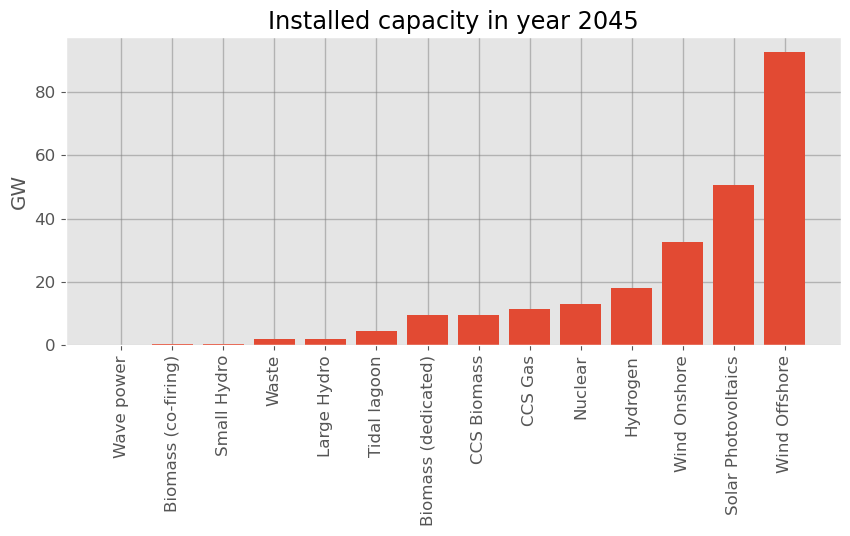

In [11]:
generators_p_nom = network.generators.p_nom.groupby(
    network.generators.carrier).sum().sort_values()
if year > 2020:
    generators_p_nom.drop('Unmet Load', inplace=True)
generators_p_nom.drop(generators_p_nom[generators_p_nom < 50].index, inplace=True)

plt.rcParams.update({'font.size': 12})
# bar chart
plt.figure(figsize=(10,4))
plt.bar(generators_p_nom.index, generators_p_nom.values / 1000)
plt.xticks(generators_p_nom.index, rotation=90)
plt.ylabel('GW')
plt.grid(color='grey', linewidth=1, axis='both', alpha=0.5)
plt.title('Installed capacity in year ' + str(year))
plt.show()

In [12]:
generators_p_nom

carrier
Wave power               171.000000
Biomass (co-firing)      224.400000
Small Hydro              252.495941
Waste                   1809.134000
Large Hydro             1926.906038
Tidal lagoon            4505.000000
Biomass (dedicated)     9456.737510
CCS Biomass             9600.717370
CCS Gas                11360.000000
Nuclear                12922.000000
Hydrogen               18026.805006
Wind Onshore           32663.170000
Solar Photovoltaics    50666.540000
Wind Offshore          92649.070000
Name: p_nom, dtype: float64

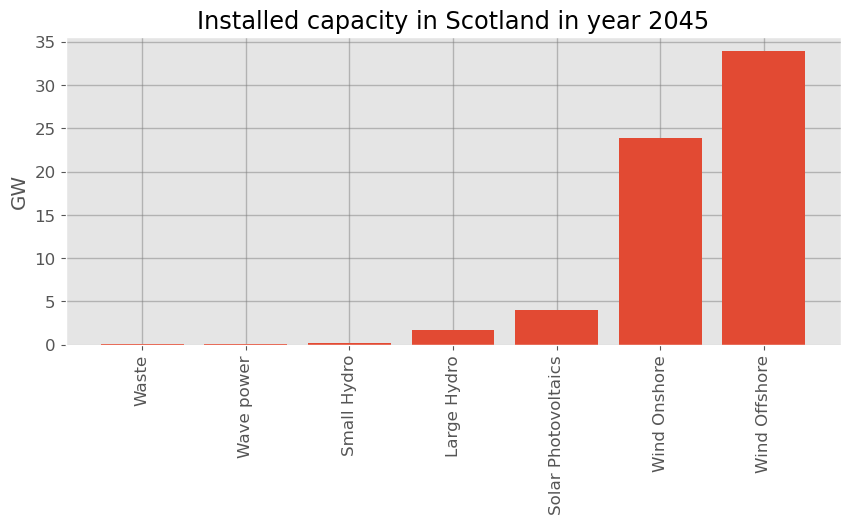

In [13]:
buses_scotland = ['Beauly', 'Peterhead', 'Errochty', 'Denny/Bonnybridge', 'Neilston', 'Strathaven', 'Torness', 'Eccles']
df_generators_scotland = network.generators[network.generators.bus.isin(buses_scotland)]

generators_p_nom_scotland = df_generators_scotland.p_nom.groupby(
    df_generators_scotland.carrier).sum().sort_values()
if year > 2020:
    generators_p_nom_scotland.drop('Unmet Load', inplace=True)
generators_p_nom_scotland.drop(generators_p_nom_scotland[generators_p_nom_scotland < 50].index, inplace=True)

plt.rcParams.update({'font.size': 12})
# bar chart
plt.figure(figsize=(10,4))
plt.bar(generators_p_nom_scotland.index, generators_p_nom_scotland.values / 1000)
plt.xticks(generators_p_nom_scotland.index, rotation=90)
plt.ylabel('GW')
plt.grid(color='grey', linewidth=1, axis='both', alpha=0.5)
plt.title('Installed capacity in Scotland in year ' + str(year))
plt.show()

In [14]:
generators_p_nom_scotland

carrier
Waste                     62.176000
Wave power               113.000000
Small Hydro              230.913108
Large Hydro             1691.699577
Solar Photovoltaics     3947.294084
Wind Onshore           23890.538179
Wind Offshore          33901.090000
Name: p_nom, dtype: float64

In [15]:
buses_scotland = ['Beauly', 'Peterhead', 'Errochty', 'Denny/Bonnybridge', 'Neilston', 'Strathaven', 'Torness', 'Eccles']
df_storage_scotland = network.storage_units[network.storage_units.bus.isin(buses_scotland)]
storage_by_carrier_scotland = df_storage_scotland.p_nom.groupby(df_storage_scotland.carrier).sum()
storage_by_carrier_scotland

carrier
Battery                          2111.132824
Compressed Air                   1104.358621
Liquid Air                        552.993103
P2G                             11866.078040
Pumped Storage Hydroelectric     2012.000000
Name: p_nom, dtype: float64

In [16]:
network.lopf(network.snapshots, solver_name="gurobi", pyomo=False)

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.64s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Set parameter Username
Academic license - for non-commercial use only - expires 2023-10-19
Read LP format model from file C:\Users\alyden\AppData\Local\Temp\pypsa-problem-swmuh18m.lp
Reading time = 0.85 seconds
obj: 417904 rows, 130646 columns, 733898 nonzeros
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 417904 rows, 130646 columns and 733898 nonzeros
Model fingerprint: 0x5a3ee114
Coefficient statistics:
  Matrix range     [6e-05, 1e+00]
  Objective range  [1e+00, 1e+09]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-05, 5e+12]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 392825 rows and 52004 columns
Presolve time: 0.37s
Presolved: 25079 rows, 79506 columns, 152889 nonzeros

Ordering time: 0.25s

Barrier statist

INFO:pypsa.linopf:Optimization successful. Objective value: 5.66e+07


('ok', 'optimal')

In [23]:
p_by_carrier = network.generators_t.p.groupby(
    network.generators.carrier, axis=1).sum()

storage_by_carrier = network.storage_units_t.p.groupby(
    network.storage_units.carrier, axis=1).sum()

# to show on graph set the negative storage values to zero
storage_by_carrier[storage_by_carrier < 0] = 0

p_by_carrier = pd.concat([p_by_carrier, storage_by_carrier], axis=1)

# group biomass stuff
p_by_carrier['Biomass'] = (
    p_by_carrier['Biomass (dedicated)'] + p_by_carrier['Biomass (co-firing)'])

# rename the hydro bit
p_by_carrier = p_by_carrier.rename(
    columns={'Large Hydro': 'Hydro'})

p_by_carrier

carrier,Biomass (co-firing),Biomass (dedicated),CCS Biomass,CCS Gas,Coal,Hydrogen,Hydro,Natural Gas,Nuclear,Oil,...,Waste,Wave power,Wind Offshore,Wind Onshore,Battery,Compressed Air,Liquid Air,P2G,Pumped Storage Hydroelectric,Biomass
snapshot,,,,,,,,,,,,,,,,,,,,,
2045-12-04 20:00:00,163.812,6903.418379,0.0,0.000000,0.0,6441.185251,214.905035,0.0,9433.060000,0.0,...,0.0,6.03200,30245.797863,4416.614206,9115.110376,2202.118738,895.309677,0.0,3094.857773,7067.230379
2045-12-04 21:00:00,163.812,6903.418379,0.0,0.000000,0.0,6441.185251,162.331700,0.0,9433.060000,0.0,...,0.0,2.70686,29433.736051,4084.653755,4932.469450,1754.265876,1036.862070,0.0,3300.224324,7067.230379
2045-12-04 22:00:00,163.812,6903.418379,0.0,0.000000,0.0,6441.185251,83.317974,0.0,9433.060000,0.0,...,0.0,2.70686,29478.271642,4072.059971,2436.011123,1518.493108,276.496552,0.0,3092.037704,7067.230379
2045-12-04 23:00:00,163.812,6903.418379,0.0,0.000000,0.0,6441.185251,81.780743,0.0,9433.060000,0.0,...,0.0,2.70686,26473.067425,4380.045246,1401.886052,1836.315759,276.496552,0.0,3042.568333,7067.230379
2045-12-05 00:00:00,163.812,6903.418379,0.0,0.000000,0.0,6441.185251,46.731853,0.0,9433.060000,0.0,...,0.0,2.86114,25300.399765,4810.574633,3794.011762,1242.403452,622.117242,0.0,1807.857957,7067.230379
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2045-12-10 16:00:00,163.812,6566.785257,0.0,289.475207,0.0,6391.627899,466.920426,0.0,7825.557830,0.0,...,0.0,5.72286,44805.146646,3434.193286,183.573332,426.902683,342.316573,0.0,3300.224324,6730.597257
2045-12-10 17:00:00,163.812,6566.785257,0.0,278.365501,0.0,7229.020103,753.523903,0.0,7962.659904,0.0,...,0.0,5.72286,44309.516812,3439.031210,1722.387824,1817.638105,500.479836,0.0,3300.224324,6730.597257
2045-12-10 18:00:00,163.812,6566.785257,0.0,0.000000,0.0,6391.627899,937.542372,0.0,8031.584908,0.0,...,0.0,5.72286,44971.236009,3382.007542,2367.016748,2754.298050,1025.615942,0.0,3300.224324,6730.597257


Text(0.5, 0, '')

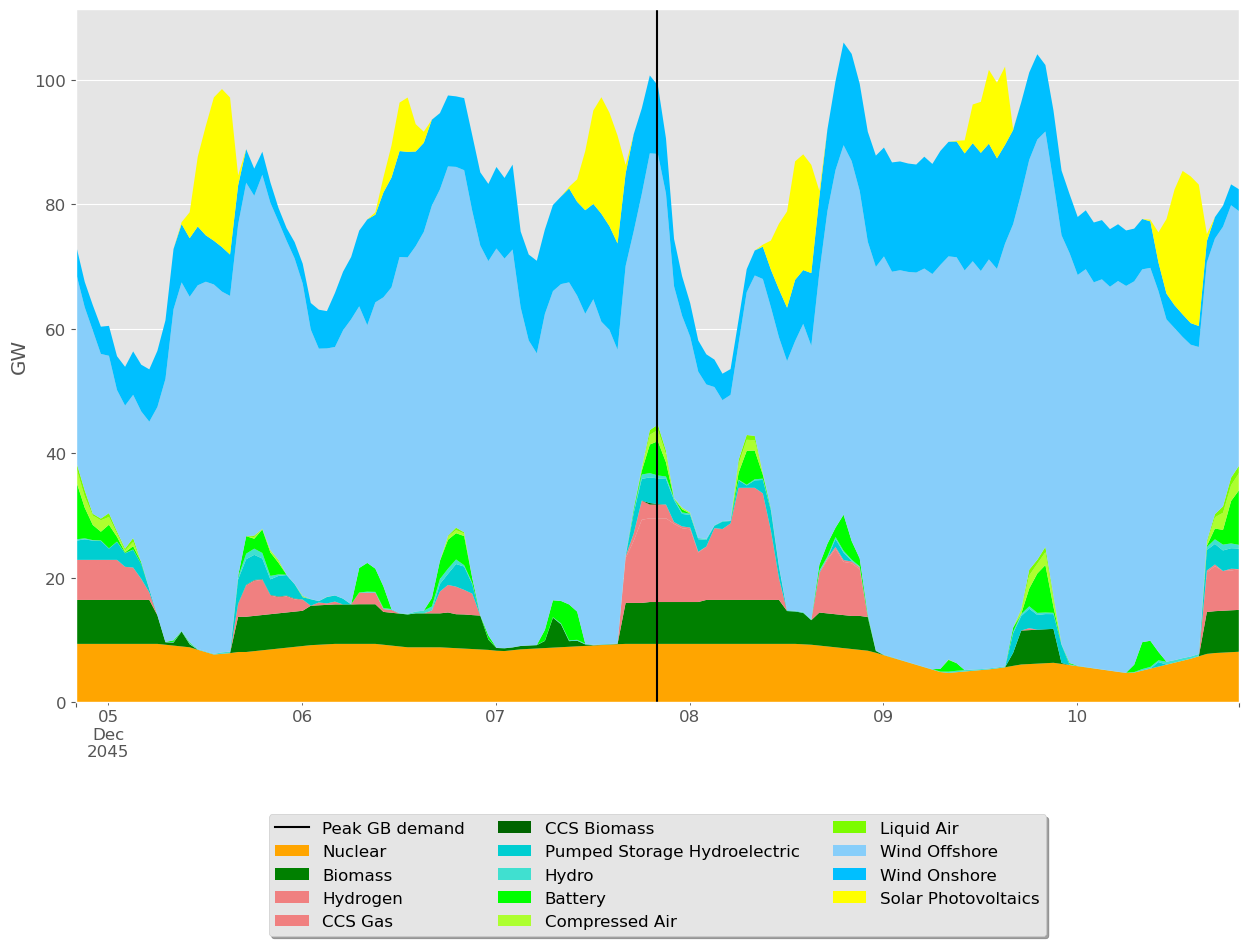

In [24]:
cols = ["Nuclear", 'Biomass',
        'Waste', "Oil", "Natural Gas",
        'Hydrogen', 'CCS Gas', 'CCS Biomass',
        "Pumped Storage Hydroelectric", 'Hydro',
        'Battery', 'Compressed Air', 'Liquid Air',
        "Wind Offshore", 'Wind Onshore', 'Solar Photovoltaics',
        'Unmet Load'
        ]

p_by_carrier = p_by_carrier[cols]

p_by_carrier.drop(
    (p_by_carrier.max()[p_by_carrier.max() < 50.0]).index,
    axis=1, inplace=True)


colors = {"Coal": "grey",
          "Diesel/Gas oil": "black",
          "Diesel/gas Diesel/Gas oil": "black",
          'Oil': 'black',
          'Unmet Load': 'black',
          'Anaerobic Digestion': 'green',
          'Waste': 'chocolate',
          'Sewage Sludge Digestion': 'green',
          'Landfill Gas': 'green',
          'Biomass (dedicated)': 'green',
          'Biomass (co-firing)': 'green',
          'Biomass': 'green',
          'CCS Biomass': 'darkgreen',
          'Interconnectors Import': 'pink',
          "Sour gas": "lightcoral",
          "Natural Gas": "lightcoral",
          'CCS Gas': "lightcoral",
          'Hydrogen': "lightcoral",
          "Nuclear": "orange",
          'Shoreline Wave': 'aqua',
          'Tidal Barrage and Tidal Stream': 'aqua',
          'Hydro': "turquoise",
          "Large Hydro": "turquoise",
          "Small Hydro": "turquoise",
          "Pumped Storage Hydroelectric": "darkturquoise",
          'Battery': 'lime',
          'Compressed Air': 'greenyellow',
          'Liquid Air': 'lawngreen',
          "Wind Offshore": "lightskyblue",
          'Wind Onshore': 'deepskyblue',
          'Solar Photovoltaics': 'yellow'}

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15,10)
(p_by_carrier / 1e3).plot(
    kind="area", ax=ax, linewidth=0,
    color=[colors[col] for col in p_by_carrier.columns])

# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
plt.axvline(x = '2045-12-07 20:00:00', color = 'black', label = 'Peak GB demand')
# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, shadow=True, ncol=3)

ax.set_ylabel("GW")

ax.set_xlabel("")

In [25]:

buses_scotland = ['Beauly', 'Peterhead', 'Errochty', 'Denny/Bonnybridge', 'Neilston', 'Strathaven', 'Torness', 'Eccles']
df_generators_scotland = network.generators[network.generators.bus.isin(buses_scotland)]
df_storage_scotland = network.storage_units[network.storage_units.bus.isin(buses_scotland)]

p_by_carrier_scotland = network.generators_t.p[df_generators_scotland.index.values].groupby(
    network.generators.carrier, axis=1).sum()

storage_by_carrier_scotland = network.storage_units_t.p[df_storage_scotland.index.values].groupby(
    network.storage_units.carrier, axis=1).sum()

# to show on graph set the negative storage values to zero
storage_by_carrier_scotland[storage_by_carrier_scotland < 0] = 0

p_by_carrier_scotland = pd.concat([p_by_carrier_scotland, storage_by_carrier_scotland], axis=1)

In [26]:
network.lines_t.p0[['17', '18', '23', '24', '16']]
B6_to_scotland = network.lines_t.p0[['17', '18', '23', '24', '16']]

B6_import = B6_to_scotland.copy()
B6_export = B6_to_scotland.copy()

B6_import[B6_import > 0] = 0
B6_import = B6_import.sum(axis=1) * -1

B6_export[B6_export < 0] = 0
B6_export = B6_export.sum(axis=1) * -1
B6_export.name = 'B6 export'

snapshot
2045-12-04 20:00:00   -3927.554401
2045-12-04 21:00:00   -4318.825985
2045-12-04 22:00:00   -4596.171220
2045-12-04 23:00:00   -5076.042000
2045-12-05 00:00:00   -5233.375348
                          ...     
2045-12-10 16:00:00   -1659.163373
2045-12-10 17:00:00   -1386.710115
2045-12-10 18:00:00   -2272.186053
2045-12-10 19:00:00   -1403.622273
2045-12-10 20:00:00   -1625.062102
Name: B6 export, Length: 145, dtype: float64


c:\Users\alyden\Anaconda3\envs\PyPSA-GB\lib\site-packages\pandas\plotting\_matplotlib\core.py:1391: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim(None, 0)


Text(0.5, 0, '')

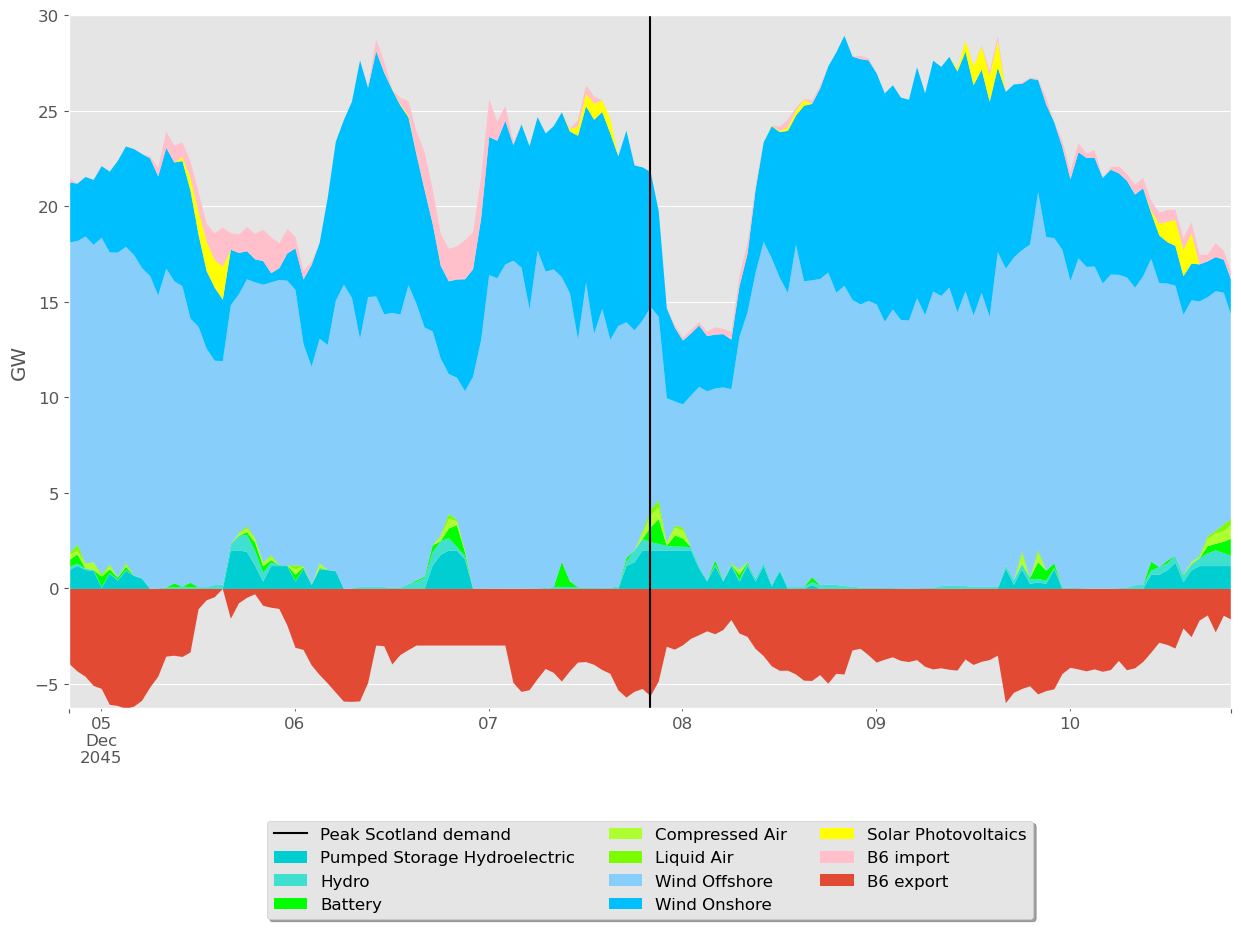

In [27]:
# group biomass stuff
p_by_carrier_scotland['Biomass'] = (
    p_by_carrier_scotland['Biomass (dedicated)'])

# add B6 flows
p_by_carrier_scotland['B6 import'] = B6_import

# rename the hydro bit
p_by_carrier_scotland = p_by_carrier_scotland.rename(
    columns={'Large Hydro': 'Hydro'})
p_by_carrier_scotland = p_by_carrier_scotland.rename(
    columns={'Interconnector': 'Interconnectors Import'})

cols = ['Biomass',
        'Waste', "Oil", "Natural Gas",
        'Hydrogen', 'CCS Gas', 'CCS Biomass',
        "Pumped Storage Hydroelectric", 'Hydro',
        'Battery', 'Compressed Air', 'Liquid Air',
        "Wind Offshore", 'Wind Onshore', 'Solar Photovoltaics',
        'Unmet Load', 'B6 import'
        ]

p_by_carrier_scotland = p_by_carrier_scotland[cols]

p_by_carrier_scotland.drop(
    (p_by_carrier_scotland.max()[p_by_carrier_scotland.max() < 50.0]).index,
    axis=1, inplace=True)


colors = {"Coal": "grey",
          "Diesel/Gas oil": "black",
          "Diesel/gas Diesel/Gas oil": "black",
          'Oil': 'black',
          'Unmet Load': 'black',
          'Anaerobic Digestion': 'green',
          'Waste': 'chocolate',
          'Sewage Sludge Digestion': 'green',
          'Landfill Gas': 'green',
          'Biomass (dedicated)': 'green',
          'Biomass (co-firing)': 'green',
          'Biomass': 'green',
          'CCS Biomass': 'darkgreen',
          'Interconnectors Import': 'pink',
          'B6 import': 'pink',
          "Sour gas": "lightcoral",
          "Natural Gas": "lightcoral",
          'CCS Gas': "lightcoral",
          'Hydrogen': "lightcoral",
          "Nuclear": "orange",
          'Shoreline Wave': 'aqua',
          'Tidal Barrage and Tidal Stream': 'aqua',
          'Hydro': "turquoise",
          "Large Hydro": "turquoise",
          "Small Hydro": "turquoise",
          "Pumped Storage Hydroelectric": "darkturquoise",
          'Battery': 'lime',
          'Compressed Air': 'greenyellow',
          'Liquid Air': 'lawngreen',
          "Wind Offshore": "lightskyblue",
          'Wind Onshore': 'deepskyblue',
          'Solar Photovoltaics': 'yellow'}

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15,10)
(p_by_carrier_scotland / 1e3).plot(
    kind="area", ax=ax, linewidth=0,
    color=[colors[col] for col in p_by_carrier_scotland.columns])

# stacked area plot of negative values, prepend column names with '_' such that they don't appear in the legend
(B6_export / 1e3).plot.area(ax=ax, stacked=True, linewidth=0.)
# rescale the y axis
print(B6_export)
# ax.set_ylim(B6_export.min() / 1e3, (p_by_carrier_scotland / 1e3).sum(axis=1).max())
ax.set_ylim(B6_export.min() / 1e3, 30)

# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
plt.axvline(x = '2045-12-07 20:00:00', color = 'black', label = 'Peak Scotland demand')
# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, shadow=True, ncol=3)
# ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
#           fancybox=True, shadow=True, ncol=5)
ax.set_ylabel("GW")

ax.set_xlabel("")


## Import and export analysis

In [28]:
# GWh
df_import_export = pd.concat([B6_import, B6_export * -1], axis=1) / 1000
df_import_export.columns = ['B6 Import', 'B6 Export']
df_import_export.sum()
# df_import_export = df_import_export.groupby(df_import_export.index.to_period('M')).sum()
# df_import_export.index = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
# df_import_export.plot(kind="bar", rot=0, figsize=(11.69, 8.27))
# plt.ylabel('TWh')
# plt.xlabel('2021')
# plt.grid(color='grey', linewidth=1, axis='both', alpha=0.5)

B6 Import     60.490015
B6 Export    537.888401
dtype: float64